In [3]:
# imports
import osmnx as ox
import numpy as np
import pyvista as pv
from shapely.geometry import Polygon, MultiPolygon
from pathlib import Path
import random


In [4]:
# extract OSM data for New Delhi

def extract_osm_data(location, radius = 500):

    # extract center point for the location
    center_point = ox.geocoder.geocode(location)

    # retrieve buildings based on center point, radius and tags
    buildings = ox.features_from_point(
        center_point,
        tags = {'building': True},
        dist = radius
    )

    # retrieve streets based on center point, radius and network type
    streets = ox.graph_from_point(
        center_point,
        dist = radius, 
        network_type = 'drive',
        simplify = False
    )

    # convert buildings to GeoDataFrame and set CRS (Coordinate Reference System)
    buildings = buildings.to_crs(epsg = 7760)

    # convert streets to GeoDataFrame and set CRS
    streets = ox.project_graph(streets, to_crs = 'epsg:7760')
    print(f"Downloaded {len(buildings)} buildings and {len(streets.edges())} street segments.")

    return buildings, streets


In [9]:
geodata = extract_osm_data("New Delhi, India", radius=500)

Downloaded 106 buildings and 312 street segments.


In [12]:
geodata[0].columns

Index(['geometry', 'building', 'name', 'nohousenumber', 'alt_name:ar',
       'alt_name:ks', 'alt_name:ur', 'internet_access', 'long_name',
       'long_name:ur', 'name:ar', 'name:az-Arab', 'name:azb', 'name:de',
       'name:el', 'name:es', 'name:grc', 'name:hi', 'name:hy', 'name:hyw',
       'name:ks', 'name:ml', 'name:pa', 'name:ug', 'name:ur', 'network',
       'operator', 'public_transport', 'railway', 'ref', 'train', 'wikipedia',
       'wikipedia:ur', 'amenity', 'name:ru', 'building:levels', 'roof:shape',
       'building:colour', 'name:en', 'building:levels:underground', 'historic',
       'tourism', 'addr:district', 'addr:housename', 'addr:state',
       'addr:street', 'landuse', 'layer', 'building:use', 'roof:colour',
       'type'],
      dtype='object')

In [14]:
# generate building footprints

def generate_footprints(buildings):

    # convert GeoDataFrame extracted from OSM into polygons

    footprints = []
    for g in buildings.geometry:
        if isinstance(g, MultiPolygon):
            # iterate through each polygon in MultiPolygon and split into individual polygons
            footprints.extend(list(g.geoms))
        elif isinstance(g, Polygon):
            # Add single polygon
            footprints.append(g)

    return footprints

In [15]:
generate_footprints(geodata[0])

[<POLYGON ((1022126.355 1001962.491, 1022117.956 1001947.292, 1022120.06 1001...>,
 <POLYGON ((1022059.221 1002135.602, 1022047.986 1002115.753, 1022034.655 100...>,
 <POLYGON ((1021801.132 1002301.261, 1021703.542 1002294.896, 1021698.753 100...>,
 <POLYGON ((1021681.909 1001797.421, 1021661.659 1001935.122, 1021681.979 100...>,
 <POLYGON ((1021448.801 1001908.242, 1021436.968 1001968.101, 1021427.468 100...>,
 <POLYGON ((1021676.68 1001949.513, 1021663.728 1001947.55, 1021636.467 10021...>,
 <POLYGON ((1022125.172 1001575.242, 1022114.399 1001558.619, 1022108.692 100...>,
 <POLYGON ((1022077.962 1001546.204, 1022094.78 1001535.662, 1022091.163 1001...>,
 <POLYGON ((1022064.304 1001561.085, 1022053.404 1001544.55, 1022047.726 1001...>,
 <POLYGON ((1022079.017 1001696.689, 1022081.747 1001700.917, 1022092.799 100...>,
 <POLYGON ((1022057.764 1001622.604, 1022047.001 1001605.982, 1022041.294 100...>,
 <POLYGON ((1022004.887 1001592.171, 1022021.704 1001581.629, 1022018.087 100...>,
 <PO

In [ ]:
# create building mesh with base, walls and roof

def create_building_mesh(coords, height):

    # remove duplicate last point from polygon coordinates
    coords = coords[:-1]
    num_points = len(coords)

    # create points for base and top of building
    base_points = np.column_stack((coords, np.zeros(num_points)))
    top_points = np.column_stack((coords, np.full(num_points, height)))

    # combine base and top points
    points = np.vstack((base_points, top_points))

    # create faces

    faces = []

    # add base (as triangle fan)
    base_face = [num_points] + list(range(num_points))
    faces.extend([base_face])

    # add roof (as triangle fan)
    roof_indices = list(range(num_points, 2 * num_points))
    roof_face = [num_points] + roof_indices
    faces.extend([roof_face])

    # add walls (as quads)
    for i in range(num_points):
        next = (i+1) % num_points
        wall_face = [4, # quad face
                     i, next, # base points
                     num_points + next, num_points + i] # top points
        faces.extend(wall_face)

    return points, faces

In [17]:
# random color generation

def generate_random_colors():
    # rgb color generation
    return [random.random() for _ in range(3)]

In [22]:
# extruding buildings to create 3D mesh
def extrude_buildings(footprints):

    # extrude 2d footprints into 3D meshes

    city_mesh = pv.PolyData()
    instances_building = []
    for footprint in footprints:
        # get coordinates of the footprint
        coords = np.array(footprint.exterior.coords)

        # generate random height for the building between 10 and 50 m
        height = np.random.uniform(10, 50)

        # create building mesh
        points, faces = create_building_mesh(coords, height)
        building = pv.PolyData(points, np.hstack(faces))

        # random colors for buildings
        color = generate_random_colors()
        building['color'] = np.tile(color, (building.n_points, 1))
        instances_building.append(building)

        # add building mesh to city mesh
        if city_mesh.n_points == 0:
            city_mesh = building
        else:
            city_mesh = city_mesh.merge(building, merge_points = False)

    print("Buildings extruded and merged into city mesh.")
    return city_mesh, instances_building

Downloaded 262 buildings and 1617 street segments.
Buildings extruded and merged into city mesh.


/Users/devyanigauri/Documents/GitHub/delhi-aqi-world-model/aqi_env/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


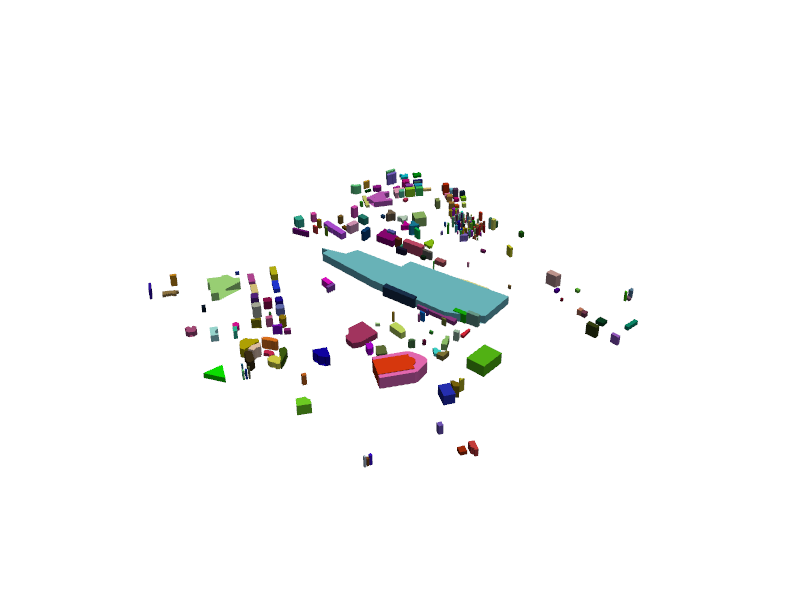

In [26]:
# 3d visualization of the city mesh

location = "New Delhi, India"
radius = 700

buildings, streets = extract_osm_data(location, radius)
footprints = generate_footprints(buildings)
city_mesh, instances_building = extrude_buildings(footprints)

p1 = pv.Plotter(border = False)
p1.add_mesh(city_mesh, scalars = 'color', rgb = True, show_edges = False)
p1.show(title = "3D City Model of New Delhi", window_size = [800, 600])